# Makemore using Multi Layer Processing
Now we look at building makemore using an MLP. Remember that makemore is a character level language model. Closely follows the following paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [94]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [],[]
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

## Building the Look Up table C
In the paper, they have 17,000 words, and cram them into a 30 dimensional space. Since we only have 27 characters, we can first try cramming them into a 2d space. 

In [11]:
C = torch.randn((27,2)) # 27 characters, 2 columns

In [13]:
C[5]

tensor([0.0067, 0.0224])

In pytorch, you can simply index by using other tensors.

In [25]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [26]:
W1 = torch.randn((6, 100)) # 2 dimensional embeddings and 3 of them = 6. 100 can be anything we want it to be
b1 = torch.randn(100)

We wish to simply do `emb @ W1 + b1`, however we cannot because [32,3,2] gets condensed into [96,2], which is unable to multiply with W1, which is [6,100]. We must condense `emb` to [32,6]

In [27]:
emb @ W1 + b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [30]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([32, 6])

In [32]:
# scalable with block size
# very inefficient. creates a whole new tensor with new storage
torch.cat(torch.unbind(emb, 1),1).shape

torch.Size([32, 6])

Below is a very efficient operation

In [33]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [39]:
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [52]:
# hidden layer 
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # look at the broadcasting for the + operation!

In [53]:
h.shape

torch.Size([32, 100])

In [51]:
h

tensor([[ 0.7728,  0.8742, -0.9810,  ...,  0.0710,  0.2884,  0.7848],
        [ 0.8686, -0.4247, -0.9786,  ..., -0.3009,  0.7894, -0.3638],
        [ 0.9618, -0.9206, -0.9214,  ..., -0.3502,  0.8768,  0.2458],
        ...,
        [-0.9597,  0.9883,  0.7519,  ..., -0.9713,  0.9058, -1.0000],
        [ 1.0000, -0.9996, -0.9994,  ...,  0.9322,  0.9766,  0.9255],
        [-0.9962,  0.6516,  0.9970,  ..., -0.6069, -0.0959, -0.8234]])

In [54]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [55]:
logits = h @ W2 + b2

In [56]:
logits.shape

torch.Size([32, 27])

In [58]:
counts = logits.exp()

In [64]:
prob = counts / counts.sum(1, keepdims=True)

In [65]:
prob.shape

torch.Size([32, 27])

In [73]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(16.3318)

## What we have so far

In [208]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [259]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g) # 10 dimensional embeddings
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [260]:
sum(p.nelement() for p in parameters)

11897

In [261]:
for p in parameters:
    p.requires_grad = True

Currently, we are overfitting for 32 examples, with 3481 parameters, so loss is quite low, but never 0. This is because the first character can be either an i, a or s. This makes it basically impossible to predict, however we are able to predict the intermediate characters quite well. 

How do we determine a good learning rate? 

In [262]:
# creates 1000 numbers between 0.001 and 1
lre = torch.linspace(-3, 0, 1000) # learning rate exponent
lrs = 10**lre

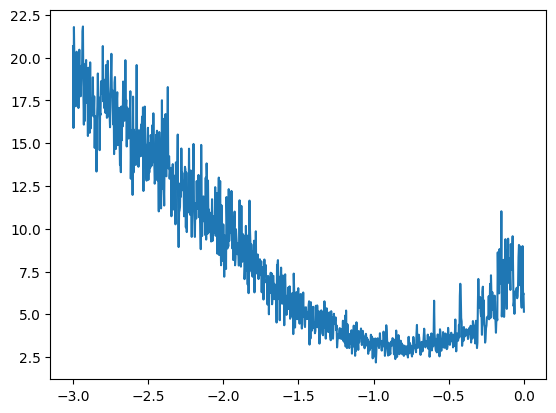

In [164]:
# plots the learning rate exponent 
plt.plot(lri,lossi)

In [263]:
lri = []
lossi = []
stepi = []

In [273]:
for i in range(50000):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32,100)
    logits = h @ W2 + b2 # (32,27)
    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdims=True)
    #loss = -prob[torch.arange(32), Y].log().mean()
    
    # below is much more efficient, but equivalent to the 3 commented lines out. as well, its simpler for backpropagation
    loss = F.cross_entropy(logits, Ytr[ix]) 
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)

print(loss.item())

2.2699973583221436


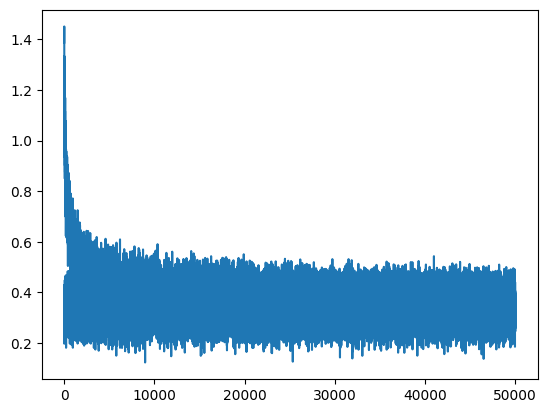

In [274]:
plt.plot(stepi, lossi)

Notice the downtime between printing each loss value. Let us address this inefficiency, by creating mini batches of the entire dataset. But why? We are no longer calculating the exact gradient, but the approximate gradient. 

It is MUCH better to find the approximate gradient and make more steps, than it is to evaluate the exact gradient and take fewer steps. This is because it is much less computationally expensive. 

In [253]:
# Calculating the exact loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits, Ydev) 
loss.item()

2.236973285675049

While the model may appear to be performing better (better than BiGram at least, which had 2.5), the model may be overfitting our dataset. In production, we must split the dataset into 3. The training split (80%), the dev/validation split (10%) and the test split (10%). 

In [196]:
# build the dataset
def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [],[]
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int (0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # training, 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # dev/validation, 10% = [n1:n2] = n2 - n1
Xte, Yte = build_dataset(words[n2:]) # test, 10% = [n2:]

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [232]:
# Calculating the loss for the dev dataset
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits, Ydev) 
print(f"Dev dataset loss: {loss.item()}")

Dev dataset loss: 2.4941234588623047


In [233]:
# Calculating the loss for the training dataset
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits, Ytr) 
print(f"Training dataset loss: {loss.item()}")

Training dataset loss: 2.468315839767456


We can see that our loss for both of our datasets is more or less equal. This is called underfitting. What this means is that our model isn't large enough to simply "memorize" the training data, thus making it overfit. Now we can make performance improvements by simply scaling up the Neural Net. 

Below is after we increased the amount of neurons from 100 to 300.

In [254]:
# Calculating the loss for the dev dataset
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits, Ydev) 
print(f"Dev dataset loss: {loss.item()}")

Dev dataset loss: 2.236973285675049


In [255]:
# Calculating the loss for the training dataset
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits, Ytr) 
print(f"Training dataset loss: {loss.item()}")

Training dataset loss: 2.1980414390563965


Our increases isn't too much, so perhaps our bottleneck is now our character embeddings, which was 2. Below is code to visualize how our model embeds the characters in 2D space. 

Recall that the character embedding simply tells us the groupings of the most similar characters.

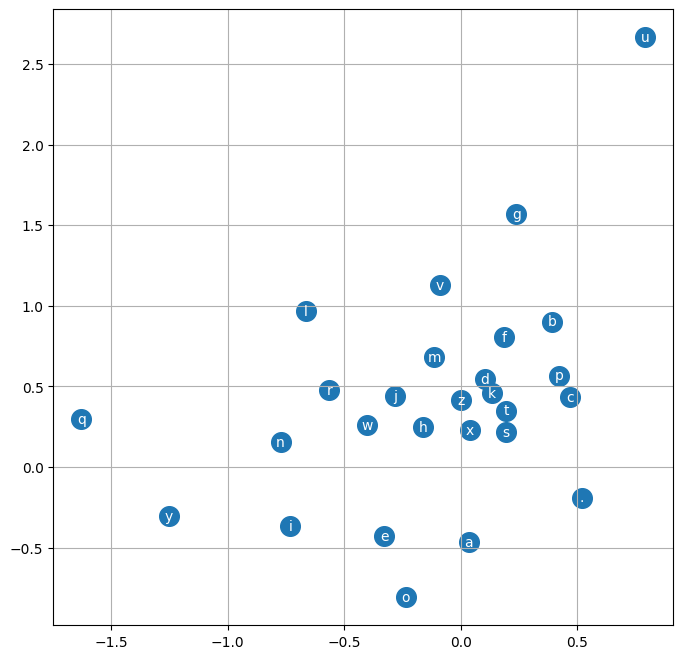

In [257]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [275]:
# Calculating the loss for the dev dataset
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits, Ydev) 
print(f"Dev dataset loss: {loss.item()}")

Dev dataset loss: 2.203322649002075


In [276]:
# Calculating the loss for the training dataset
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32,27)
loss = F.cross_entropy(logits, Ytr) 
print(f"Training dataset loss: {loss.item()}")

Training dataset loss: 2.160154342651367


## Challenge: Beat Karpathy's loss value by fine tuning the model
He achieved a loss of 2.17 for the dev set. Try to change the values of the model such that the loss value will be lower. 

In [294]:
neuron_count = 400
embedding_dimension = 14
inputs = embedding_dimension * 3 # because the neural net always takes 3 inputs, so we multiply by 3 for inputs towards the hidden layer
steps = 300000

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,embedding_dimension), generator=g) # 10 dimensional embeddings
W1 = torch.randn((inputs,neuron_count), generator=g)
b1 = torch.randn(neuron_count, generator=g)
W2 = torch.randn((neuron_count,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [295]:
for i in range(steps):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (200,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,inputs) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix]) 
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # crappy learning rate decay
    if (i < 100000):
        lr = 0.1
    elif (i < 200000):
        lr = 0.01
    elif (i < 300000): 
        lr = 0.005
    else:
        lr = 0.0005
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)

print(loss.item())

1.9699676036834717


In [296]:
# Calculating the loss for the dev dataset
emb = C[Xdev]
h = torch.tanh(emb.view(-1,inputs) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev) 
print(f"Dev dataset loss: {loss.item()}")

Dev dataset loss: 2.1503283977508545


We got a loss of 2.15! All I did was simply:
1. Increase amount of neurons
2. Increase the embedding dimension
3. Increased the mini-batch size
4. Optimized the learning rate decay

### Sampling

In [298]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(30):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1)@ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carmah.
amelle.
khyrmin.
reety.
ska.
sane.
rah.
bradeliah.
jarquil.
ramari.
chaily.
kaleigh.
ham.
join.
quinthonoveri.
jadis.
waterri.
jarynix.
kaellivran.
edde.
isa.
gian.
jasri.
alpan.
benjiksyn.
pamboton.
ajanel.
calairae.
ekrisa.
luco.


Not too bad. Notice how the model picked up on how 'q' is always followed by a 'u'. Some of the names make sense, but a majority do not. We could definitely do better. 